# Hubert Stefanski -- 20081102@mail.wit.ie -- Text-Mining -- CA

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

plt.style.use("seaborn-darkgrid")

SEED = 666


## Load Dataset and Cleanup

In [2]:
df = pd.read_csv("data/wapo_trumpclaims_export-012021.csv.gz")
print(df.shape)
df.head(2)

(30573, 9)


,id,location,claim,analysis,pinocchios,category,repeated_ids,repeated_count,date
0,31608.0,Remarks,"“We also got tax cuts, the largest tax cut and...","This is Trump’s second favorite falsehood, and...",4.0,Taxes,"31608, 31581, 31305, 31183, 31530, 30920, 3085...",296,01/20/2021
1,31609.0,Remarks,“We just got seventy five million votes. And t...,"When the counting was finished, Trump had rece...",NaN,Election,"31609, 31292, 31155, 31016, 31082, 30992, 3156...",19,01/20/2021


In [3]:
df.category.value_counts(dropna=False)

Immigration            3225
Foreign policy         3165
Election               3037
Miscellaneous          2767
Coronavirus            2521
Trade                  2513
Economy                2475
Russia                 1838
Jobs                   1732
Health care            1629
Ukraine probe          1377
Environment            1065
Biographical record     963
Taxes                   857
Crime                   852
NaN                     169
Guns                    165
Education               151
Terrorism                72
Name: category, dtype: int64

In [21]:
df.dropna(subset=['category'], inplace=True) ## Drop Na from target

print(f"Pre-duplicate drop: {df.shape}") ## Check shape before dropping duplicates

df.drop_duplicates(inplace=True) ## Drop duplicates

print(f"Post-duplicate drop: {df.shape}") ## Check shape after dropping duplicates, if they exist the shape should change

Pre-duplicate drop: (30404, 4)
Post-duplicate drop: (30355, 4)


In [5]:
def clean_text(text):
    text = re.sub(r"'", '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'pic.twitter\S+', '', text)
    text = re.sub(r'\W+', ' ', text.lower())

    return text

In [6]:
df.location.value_counts(dropna=False)

Campaign rally       9514
Remarks              6207
Interview            4971
Twitter              4703
Speech               2763
News conference      1895
Vlog                  148
Statement             123
Leaked transcript      80
Name: location, dtype: int64

In [7]:
# sns.histplot(x='date',data=df) // COMMENTED OUT DUE TO VERSION ISSUE

In [8]:
# criteria = df.category.isin(["Immigration","Coronavirus"])
df = df.loc[:,["claim","category","location","date"]].copy()

In [9]:
df.category.value_counts()

Immigration            3225
Foreign policy         3165
Election               3037
Miscellaneous          2767
Coronavirus            2521
Trade                  2513
Economy                2475
Russia                 1838
Jobs                   1732
Health care            1629
Ukraine probe          1377
Environment            1065
Biographical record     963
Taxes                   857
Crime                   852
Guns                    165
Education               151
Terrorism                72
Name: category, dtype: int64

## Feature Engineering

In [10]:
X_train, X_test, y_train, y_test = train_test_split(df['claim'], df.category, test_size=0.4, stratify = df.category ,random_state=SEED)

(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

((18242,), (18242,), (12162,), (12162,))

In [11]:
# df_train, df_test = train_test_split(df, test_size=0.4, stratify = df.category ,random_state=SEED)

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(ngram_range=(1,2))

In [13]:
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

X_test_counts.shape

(12162, 158088)

In [22]:
print(list(count_vectorizer.get_feature_names()[:100]))

['00', '00 00', '00 32', '00 americans', '00 and', '00 doing', '00 eastern', '00 gasoline', '00 in', '00 on', '00 which', '00 will', '000', '000 000', '000 100', '000 128', '000 15', '000 175', '000 200', '000 25', '000 28', '000 35', '000 40', '000 450', '000 50', '000 670', '000 70', '000 80', '000 abbott', '000 absentee', '000 acres', '000 actually', '000 additional', '000 adults', '000 aliens', '000 almost', '000 already', '000 american', '000 americans', '000 amount', '000 and', '000 applications', '000 applying', '000 apprehensions', '000 arizona', '000 arrests', '000 as', '000 assaults', '000 at', '000 bad', '000 ballots', '000 barrels', '000 beautiful', '000 because', '000 beds', '000 before', '000 black', '000 boats', '000 bonuses', '000 brand', '000 bucks', '000 burglaries', '000 burglary', '000 businesses', '000 but', '000 can', '000 car', '000 cases', '000 child', '000 commissioner', '000 communities', '000 compared', '000 construction', '000 coronavirus', '000 could', '000

In [24]:
from sklearn.feature_extraction.text import TfidfTransformer
tf = TfidfTransformer()

X_tftrain = tf.fit_transform(X_train_counts)

## Model Building

In [25]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy', max_depth=4)
svc = SVC(gamma="scale",probability=True)
mnb = MultinomialNB()
lgr = LogisticRegression(max_iter=1000,solver='lbfgs')
voting = VotingClassifier(estimators=[('logReg', lgr),('DecisionTree', dt), ('SVC', svc), ('MultiBiNom', mnb)],
                           voting='soft', n_jobs=-1)

models = [
          dt,
#           sv, ## COMMENT THIS OUT IF YOU LIKE WASTING YOUR TIME
          mnb,
          lgr,
#           voting
         ]


In [26]:
for model in models:
    model.fit(X_tftrain,y_train)
    y_pred = model.predict(X_test_counts)
    print(f"-------------{model}------------------------------------------")
    print(classification_report(y_test,y_pred,zero_division=True,digits=4))
    



-------------DecisionTreeClassifier(criterion='entropy', max_depth=4)------------------------------------------
                     precision    recall  f1-score   support

Biographical record     0.0909    0.0052    0.0098       385
        Coronavirus     1.0000    0.0357    0.0690      1008
              Crime     1.0000    0.0000    0.0000       341
            Economy     0.1538    0.0020    0.0040       990
          Education     1.0000    0.0000    0.0000        60
           Election     1.0000    0.0000    0.0000      1215
        Environment     1.0000    0.0000    0.0000       426
     Foreign policy     0.1167    0.9637    0.2081      1266
               Guns     1.0000    0.0000    0.0000        66
        Health care     1.0000    0.0000    0.0000       652
        Immigration     0.9305    0.2907    0.4430      1290
               Jobs     0.8678    0.3030    0.4492       693
      Miscellaneous     1.0000    0.0000    0.0000      1107
             Russia     1.0000   

In [17]:
print(classification_report(y_test,y_pred,zero_division=True,digits=4))

                     precision    recall  f1-score   support

Biographical record     0.6235    0.5377    0.5774       385
        Coronavirus     0.8160    0.8403    0.8280      1008
              Crime     0.7266    0.5924    0.6527       341
            Economy     0.7662    0.7747    0.7705       990
          Education     0.9804    0.8333    0.9009        60
           Election     0.7218    0.7646    0.7426      1215
        Environment     0.8617    0.7019    0.7736       426
     Foreign policy     0.8192    0.8555    0.8369      1266
               Guns     0.9273    0.7727    0.8430        66
        Health care     0.8681    0.8482    0.8580       652
        Immigration     0.8710    0.8845    0.8777      1290
               Jobs     0.8218    0.8052    0.8134       693
      Miscellaneous     0.5109    0.5727    0.5400      1107
             Russia     0.8209    0.8109    0.8159       735
              Taxes     0.9292    0.8805    0.9042       343
          Terrorism    

In [18]:
df_cm = pd.crosstab(y_test,y_pred)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
df_cm

Predicted,Biographical record,Coronavirus,Crime,Economy,Education,Election,Environment,Foreign policy,Guns,Health care,Immigration,Jobs,Miscellaneous,Russia,Taxes,Terrorism,Trade,Ukraine probe
Actual,,,,,,,,,,,,,,,,,,
Biographical record,207,7,0,16,0,30,0,17,0,3,4,0,86,6,2,0,4,3
Coronavirus,1,847,4,21,0,19,1,16,0,5,14,9,50,8,1,0,6,6
Crime,2,9,202,4,0,23,0,5,0,3,31,1,48,7,0,0,4,2
Economy,6,25,3,767,1,16,12,18,0,4,7,66,27,2,5,0,31,0
Education,1,0,1,0,50,3,0,1,0,1,1,0,1,0,0,0,1,0
Election,28,22,19,13,0,929,1,14,1,2,16,2,119,26,4,0,1,18
Environment,5,17,0,24,0,17,299,14,0,1,2,8,28,0,1,0,10,0
Foreign policy,7,21,4,14,0,17,5,1083,0,2,11,2,48,17,0,2,26,7
Guns,0,3,0,2,0,3,0,1,51,1,1,0,4,0,0,0,0,0


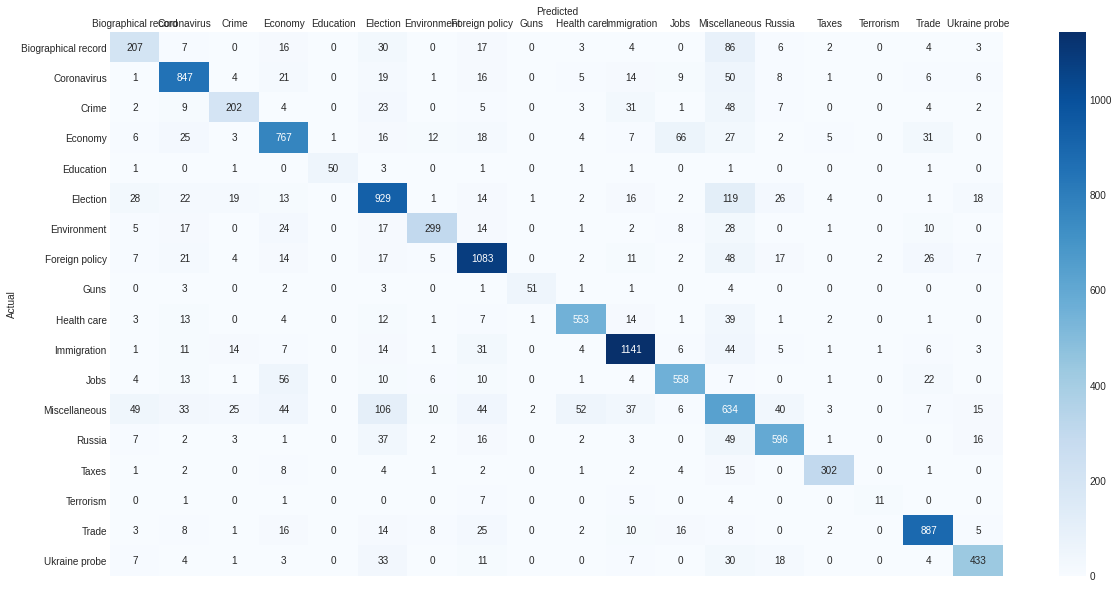

In [19]:
plt.figure(figsize=(20,10))
g = sns.heatmap(df_cm,annot=True,fmt="d",cmap="Blues")
g.xaxis.set_ticks_position('top')
g.xaxis.set_label_position('top')

In [20]:
print(classification_report(y_test, y_pred, zero_division=0, digits=4))

                     precision    recall  f1-score   support

Biographical record     0.6235    0.5377    0.5774       385
        Coronavirus     0.8160    0.8403    0.8280      1008
              Crime     0.7266    0.5924    0.6527       341
            Economy     0.7662    0.7747    0.7705       990
          Education     0.9804    0.8333    0.9009        60
           Election     0.7218    0.7646    0.7426      1215
        Environment     0.8617    0.7019    0.7736       426
     Foreign policy     0.8192    0.8555    0.8369      1266
               Guns     0.9273    0.7727    0.8430        66
        Health care     0.8681    0.8482    0.8580       652
        Immigration     0.8710    0.8845    0.8777      1290
               Jobs     0.8218    0.8052    0.8134       693
      Miscellaneous     0.5109    0.5727    0.5400      1107
             Russia     0.8209    0.8109    0.8159       735
              Taxes     0.9292    0.8805    0.9042       343
          Terrorism    